# Advanced ML: Домашнее задание 2

1. Скачайте данные в формате csv, выберите из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases); для упрощения обработки можно заменить в столбце new_cases все нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания).

In [1]:
import pandas as pd
from sklearn import linear_model
import numpy as np
import seaborn as sns
import scipy.stats as sps

In [2]:
df_covid = pd.read_csv('owid-covid-data.csv')

In [3]:
df_covid.head()

,iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,...,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_100k
0,ABW,Aruba,2020-03-13,2,2,0,0,18.733,18.733,0.0,...,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN
1,ABW,Aruba,2020-03-20,4,2,0,0,37.465,18.733,0.0,...,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN
2,ABW,Aruba,2020-03-24,12,8,0,0,112.395,74.930,0.0,...,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN
3,ABW,Aruba,2020-03-25,17,5,0,0,159.227,46.831,0.0,...,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN
4,ABW,Aruba,2020-03-26,19,2,0,0,177.959,18.733,0.0,...,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN


In [4]:
df_covid['date'].dtypes

dtype('O')

In [5]:
df_covid['date'] = df_covid['date'].apply(pd.to_datetime)

In [6]:
df_covid_rus = df_covid[df_covid['location'] == 'Russia'][['date','total_cases', 'new_cases']]

In [7]:
df_covid_rus = df_covid_rus[df_covid_rus['date'] >= pd.Timestamp(year=2020, month=3, day=3)]

In [8]:
df_covid_rus['day_count'] = df_covid_rus['date'].apply( lambda x : x - pd.Timestamp(year=2020, month=3, day=3)).dt.days.astype('int16')+1

In [9]:
df_covid_rus.head()

,date,total_cases,new_cases,day_count
13614,2020-03-03,3,1,1
13615,2020-03-04,4,1,2
13616,2020-03-05,4,0,3
13617,2020-03-06,4,0,4
13618,2020-03-07,10,6,5


In [10]:
num_of_days = 50
df_train = df_covid_rus[:num_of_days]
df_test = df_covid_rus[num_of_days:]

2. Постройте графики целевых переменных. Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к снаряду давайте это и используем.

In [11]:
import matplotlib.pyplot as plt

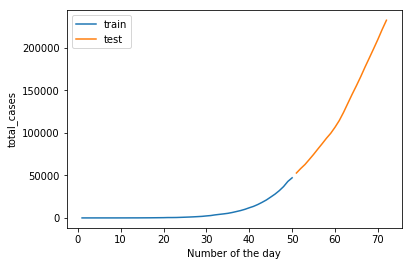

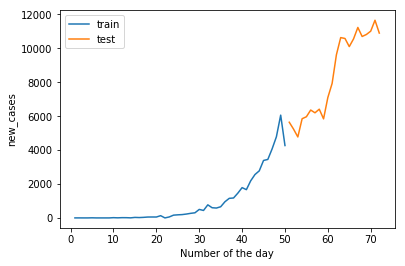

In [12]:
for col_name in df_covid_rus.columns[-3:-1]:
    plt.plot(df_train['day_count'],df_train[col_name], label = 'train')
    plt.plot(df_test['day_count'],df_test[col_name],  label = 'test')
    plt.legend()
    plt.xlabel('Number of the day')
    plt.ylabel(col_name)
    plt.show()

a). Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.

In [13]:
def train_model(xs, ys, alpha=0, use_lasso=False):
    xs = np.array(xs).reshape(-1, 1)
    ys = np.log(np.array(ys) + 0.00001)
    if alpha == 0:
        return linear_model.LinearRegression(fit_intercept=True).fit( xs, ys )
    else:
        if use_lasso:
            return linear_model.Lasso(alpha=alpha, fit_intercept=True).fit( xs, ys )
        else:
            return linear_model.Ridge(alpha=alpha, fit_intercept=True).fit( xs, ys )

In [14]:
simple_model = train_model(df_train['day_count'], df_train['total_cases'])

[0.20328034]


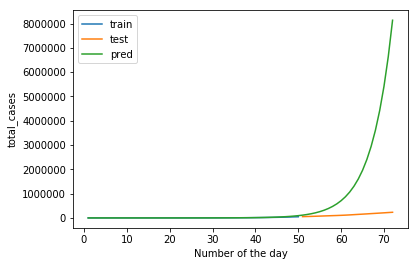

[0.32325844]


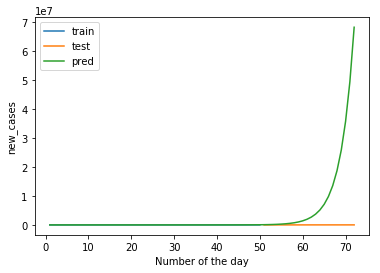

In [15]:
for col_name in df_covid_rus.columns[-3:-1]:
    model = train_model(df_train['day_count'], df_train[col_name])
    print(model.coef_)
    pred = np.exp(model.predict(pd.DataFrame(df_covid_rus['day_count'])))    
    plt.plot(df_train['day_count'],df_train[col_name], label = 'train')
    plt.plot(df_test['day_count'],df_test[col_name],  label = 'test')
    plt.plot(df_covid_rus['day_count'],pred,  label = 'pred')
    plt.legend()
    plt.xlabel('Number of the day')
    plt.ylabel(col_name)
    plt.show()

Можно пройтись гридсерчем по альфам для регуляризации, но видим, что коэффициенты и так не шибко велики, и радикального прироста качества модели мы не получим. Посмотрим чуть ближена ситуацию на трейне.


[0.20328034]


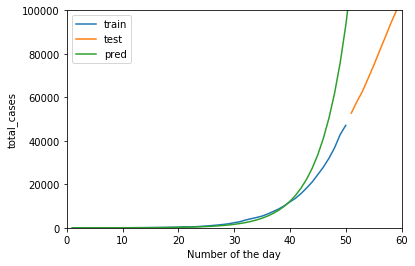

[0.32325844]


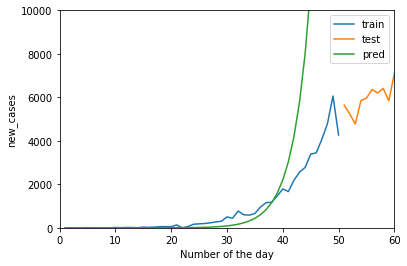

In [16]:
for col_name in df_covid_rus.columns[-3:-1]:
    model = train_model(df_train['day_count'], df_train[col_name])
    print(model.coef_)
    pred = np.exp(model.predict(pd.DataFrame(df_covid_rus['day_count'])))    
    plt.plot(df_train['day_count'],df_train[col_name], label = 'train')
    plt.plot(df_test['day_count'],df_test[col_name],  label = 'test')
    plt.plot(df_covid_rus['day_count'],pred,  label = 'pred')
    plt.legend()
    plt.xlabel('Number of the day')
    plt.ylabel(col_name)
    plt.xlim(0,60)
    if col_name == 'total_cases':
        plt.ylim(0,100000)
    else:
        plt.ylim(0,10000)
    plt.show()

Видно, что часть данных описывается моделью неплохо, но после 40го дня предсказания слишком сильно улетают от реальных данных. 

b). Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).

$$p(w) = \mathcal{N}(w|\mu_0, \Sigma_0)$$
$$p(w|D) = \mathcal{N}(w| \mu_N, \Sigma_N)$$

In [22]:
model = train_model(df_train['day_count'], df_train['total_cases'],alpha=1000)
print(model.coef_)
pred = np.exp(model.predict(pd.DataFrame(df_train['day_count'])))    
var = (np.log(pred) - np.log(df_train['total_cases'])).std()**2 #найдем \sigma^2
var_zero = var/1000 
#print(var)
print(var_zero)

[0.18546826]
0.00019882113303180659


видоизменим формулу из 2 лекции со слайда 22 с учетом того, что $\mu_o = 0, t = \ln(y)$.
$$\Sigma_N = \left(\frac{I}{\sigma_0^2} + \frac{X^T X}{\sigma^2}\right)^{-1}$$
$$\mu_N = \Sigma_N\left(\frac{X^T \ln{y}}{\sigma^2}\right)$$

In [23]:
X = np.ones((len(df_train), 2)) # по аналогии с ноутбуком с занятия
X[:, 1] = df_train['day_count']
sigma_posterior = np.linalg.inv(np.eye(2) / var_zero + (X.T @ X) / var)
mu_posterior = sigma_posterior @ (X.T @ np.log(df_train['total_cases'])) / var
print('sigma = \n{},\n mu = {}'.format(sigma_posterior,mu_posterior))

sigma = 
[[ 1.96271392e-04 -5.69712066e-06]
 [-5.69712066e-06  4.69174643e-06]],
 mu = [0.02218455 0.23503727]


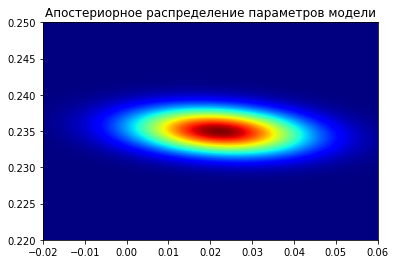

In [37]:
N = 1000
plot_lims = ((-0.02, 0.06),(0.22, 0.25))
X = np.linspace(*plot_lims[0], N)
Y = np.linspace(*plot_lims[1], N)
X, Y = np.meshgrid(X, Y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y
Z = sps.multivariate_normal.pdf(pos, mean=mu_posterior, cov=sigma_posterior)
plt.xlim(plot_lims[0])
plt.ylim(plot_lims[1])
plt.pcolormesh(X, Y, Z,cmap=plt.cm.jet)
plt.show()

с). Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).


In [30]:
import scipy.stats as sps

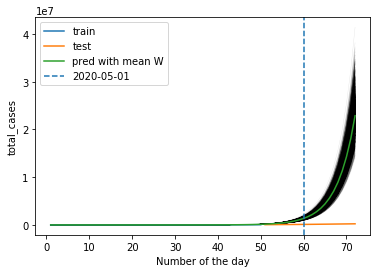

In [129]:
n=5000
X = np.ones((len(df_covid_rus), 2))
X[:, 1] = df_covid_rus['day_count']
my_w = np.random.multivariate_normal(mu_posterior, sigma_posterior, n)    
for w in my_w:
    plt.plot(X[:,1],np.exp(X@w), 'k-', lw=.4, alpha = 0.1)
plt.plot(df_train['day_count'], df_train['total_cases'], label='train')
plt.plot(df_test['day_count'], df_test['total_cases'], label='test')
plt.plot(X[:, 1], np.exp(X @ my_w.mean(axis=0)), label='pred with mean W')
for date in ['2020-05-01', '2020-06-01', '2020-09-01']:
    if (pd.to_datetime(date) - pd.to_datetime('2020-03-02')).days < 75:
        plt.axvline((pd.to_datetime(date) - pd.to_datetime('2020-03-02')).days, linestyle = '--', label = date)
plt.xlabel('Number of the day')
plt.ylabel('total_cases')
plt.legend()

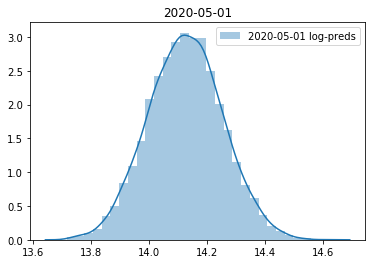

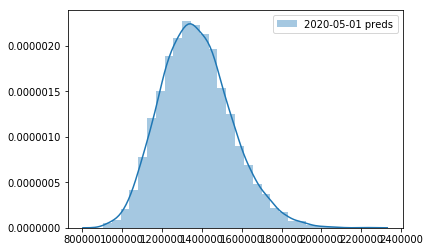

Mean log-prediction for 2020-05-01 is 14.12, mean prediction is 1373593 people


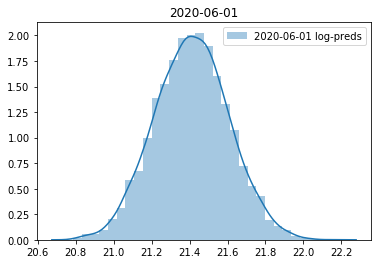

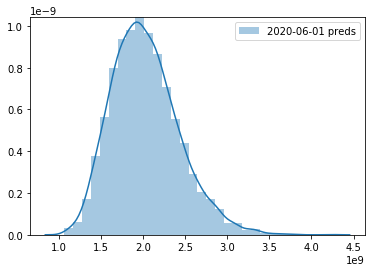

Mean log-prediction for 2020-06-01 is 21.41, mean prediction is 2027613172 people


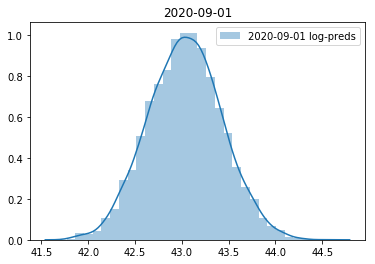

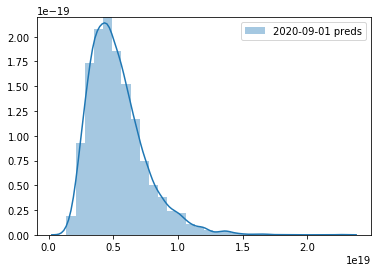

Mean log-prediction for 2020-09-01 is 43.04, mean prediction is 5292698352849486848 people


In [130]:
for date in ['2020-05-01', '2020-06-01', '2020-09-01']:    
    preds = np.zeros(my_w.shape[0])
    x = np.array([1, (pd.to_datetime(date) - pd.to_datetime('2020-03-02')).days])
    for w in range(my_w.shape[0]):
        preds[w] = x @ my_w[w, :]
    preds = pd.Series((preds))    
    sns.distplot(preds, bins=30,label = date + ' log-preds')
    plt.title(date)
    plt.legend()
    plt.show()
    preds_exp = pd.Series(np.exp(preds))
    sns.distplot(preds_exp, bins=30,label = date + ' preds')
    plt.ticklabel_format(style='sci', axis='x')
    plt.legend()
    plt.show()
    print(f'Mean log-prediction for {date} is {((preds).mean()):.2f}, mean prediction is {int(np.exp(preds).mean())} people')

3. Предсказания экспоненциальной модели наверняка получились грустными. Но это, конечно, чересчур пессимистично — экспоненциальный рост в природе никак не может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста неизбежно происходит насыщение.


a). Предложите способ обучать параметры сигмоидальной функции при помощи линейной регрессии.

Просуммировав все значения new_cases с начала ведения учета заболевших и до определенного дня, мы получим как раз значение total_cases в этот день. Иными словами, проинтегрировав new_cases, получаем total cases. Но тогда, можно сказать, исходя из наших предположений и целей задания, что new_cases(t) - экспонента, степень которой зависит от квадрата t. Прологарифмировав, получим, что: $$\ln (\text{new_cases}) = ax^2+bx+c$$ Комментарии на тему того, хорошо ли это или не особо, я бы дал в конце.

b). Обучите эти параметры на датасете случаев коронавируса в России. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели.

Характер роста изменился после 50 дня, поэтому возьмем чуть больше, раз уж можно.. Даже при таких уступках тестовый сет остается достаточного размера.

In [105]:
num_of_days = 60
df_covid_rus['new_cases'] = df_covid_rus['new_cases'].apply(lambda x: x if x != 0 else 1)
df_train = df_covid_rus[:num_of_days]
df_test = df_covid_rus[num_of_days:]
df_train['sq'] = df_train['day_count'].apply(lambda x: x**2)
df_test['sq'] = df_test['day_count'].apply(lambda x: x**2)
df_covid_rus['sq'] = df_covid_rus['day_count'].apply(lambda x: x**2)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [106]:
sigmoid_model = linear_model.Ridge(fit_intercept=True).fit(
    df_train[['day_count','sq']],
    np.log(np.array(df_train['new_cases'])))

Небольшой комментарий: при малых эпсилонах под логарифмом регрессия оверфитилась под них и пик был слишком рано, поэтому действительно пришлось заменить их на единички.

a = -0.0020043907522346023,b = 0.289453048296151,c = -1.066901232988883


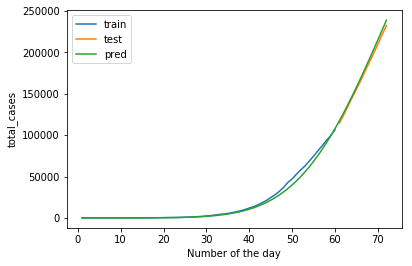

In [110]:
pred = (np.exp(sigmoid_model.predict(pd.DataFrame(df_covid_rus[['day_count','sq']])))).cumsum()
plt.plot(df_train['day_count'],df_train['total_cases'], label = 'train')
plt.plot(df_test['day_count'],df_test['total_cases'],  label = 'test')
plt.plot(df_covid_rus['day_count'],pred,  label = 'pred')
plt.legend()
plt.xlabel('Number of the day')
plt.ylabel('total_cases')
print(f'a = {sigmoid_model.coef_[1]},b = {sigmoid_model.coef_[0]},c = {sigmoid_model.intercept_}')
plt.show()

In [114]:
pred = (np.exp(sigmoid_model.predict(pd.DataFrame(df_train[['day_count','sq']]))))
var = (np.log(pred) - np.log(df_train['new_cases'])).std()**2 #найдем \sigma^2
var_zero = var/1 
#print(var)
print(var_zero)

0.5462336508106043


In [119]:
X = np.ones((len(df_train), 3))
X[:, 1:] = df_train[['day_count','sq']]
sigma_posterior = np.linalg.inv(np.eye(3)/var_zero + (X.T @ X) / var)
mu_posterior = sigma_posterior @ (X.T @ np.log(np.array(df_train['new_cases']))) / var
print('sigma = \n{},\n mu = {}'.format(sigma_posterior,mu_posterior))

sigma = 
[[ 7.54843144e-02 -4.98904825e-03  6.87122175e-05]
 [-4.98904825e-03  4.48168731e-04 -6.98844105e-06]
 [ 6.87122175e-05 -6.98844105e-06  1.16480177e-07]],
 mu = [-0.91946559  0.27970846 -0.00187018]


In [125]:
sigmoid_model.coef_

array([ 0.28945305, -0.00200439])

c). Посэмплируйте много разных сигмоид из апостериорного распределения, постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? Постройте эмпирическое предсказательное распределение, нарисуйте графики. Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?

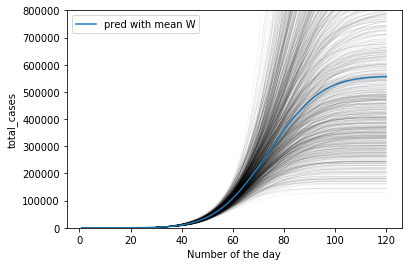

In [167]:
n=1000
max_day = 120
X = np.ones((max_day, 3))
X[:, 1] = np.arange(1, max_day+1)
X[:, 2] = np.arange(1, max_day+1)**2
my_w = np.random.multivariate_normal(mu_posterior, sigma_posterior, n)    
for w in my_w:   
    plt.plot(X[:,1],np.cumsum(np.exp(X @ w)), 'k-', lw=.4, alpha = 0.09)
plt.plot(X[:, 1], np.cumsum(np.exp(X @ my_w.mean(axis=0))), label='pred with mean W')
plt.ylim((0, 8*10**5))
plt.xlabel('Number of the day')
plt.ylabel('total_cases')
plt.legend()
plt.show()

Predictions for 2020-07-01.
10-percentile optimistic prediction: 268679
90-percentile pessimistic prediction: 1749358
Peak date: 2020-05-14 


Text(0.5, 0, 'total_cases')

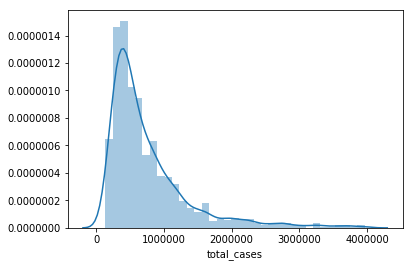

In [173]:
total_pred=[]
my_w = np.random.multivariate_normal(mu_posterior, sigma_posterior, n)    
for w in my_w:
    total_pred.append(np.cumsum(np.exp(X @ w))[-1])
total_pred=np.array(total_pred)
print(f'Predictions for { (list(df_covid_rus["date"])[0] + pd.Timedelta(days = max_day)).date()}.')
print(f'10-percentile optimistic prediction: {int(np.percentile(total_pred, 10))}')
print(f'90-percentile pessimistic prediction: {int(np.percentile(total_pred, 90))}')
print(f'Peak date: {(list(df_covid_rus["date"])[0] + pd.Timedelta(days = int(-sigmoid_model.coef_[0]/(2*sigmoid_model.coef_[1])))).date()} ')
sns.distplot(total_pred[total_pred < 4*10**6])
plt.xlabel('total_cases')

4. Проведите такой же анализ для других стран (здесь придётся руками подобрать дни начала моделирования — коронавирус приходил в разные страны в разное время). Насколько разные параметры получаются? Можно ли разделить страны на кластеры (хотя бы чисто визуально) в зависимости от этих параметров?


In [298]:
countries = set(df_covid[df_covid['total_cases']>10**5]['location'].unique())

In [299]:
countries

{'Brazil',
 'France',
 'Germany',
 'Iran',
 'Italy',
 'Russia',
 'Spain',
 'Turkey',
 'United Kingdom',
 'United States',
 'World'}

In [300]:
countries.update(np.random.choice(df_covid[df_covid['total_cases']>10**3]['location'].unique(),size = 12))

In [301]:
countries.discard('World')
countries.discard('United States')

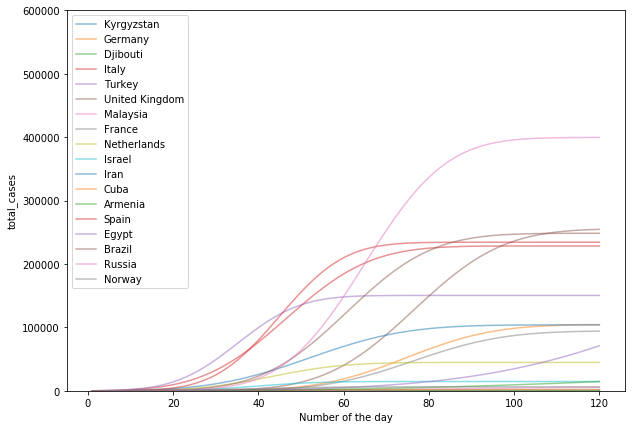

In [302]:
coefs=[]
num_days = 120
plt.figure(figsize=(10, 7))
for country in countries:
    df = df_covid[df_covid['location'] == country][['date', 'total_cases', 'new_cases']]
    df = df[df['total_cases'] >= 5]    
    df['day_count'] = np.arange(1, len(df)+1)
    df['sq'] = df['day_count'].apply(lambda x: x**2)
    df['new_cases'] = df['new_cases'].apply(lambda x: abs(x) if x != 0 else 1)
    sigmoid_model = linear_model.Ridge(alpha=0.01,fit_intercept=True).fit(df[['day_count','sq']],np.log(np.array(df['new_cases'])))
    x = np.arange(1, num_days+1)
    X = np.array([x, x**2]).T
    pred = np.exp(sigmoid_model.predict(pd.DataFrame(X))).cumsum()
    plt.plot(x, pred, label=country,alpha=0.5)
    coefs.append(sigmoid_model.coef_)
plt.legend()
plt.ylim(0,6*10**5)
plt.xlabel('Number of the day')
plt.ylabel('total_cases')
plt.show()

(-0.0041, 0.0)

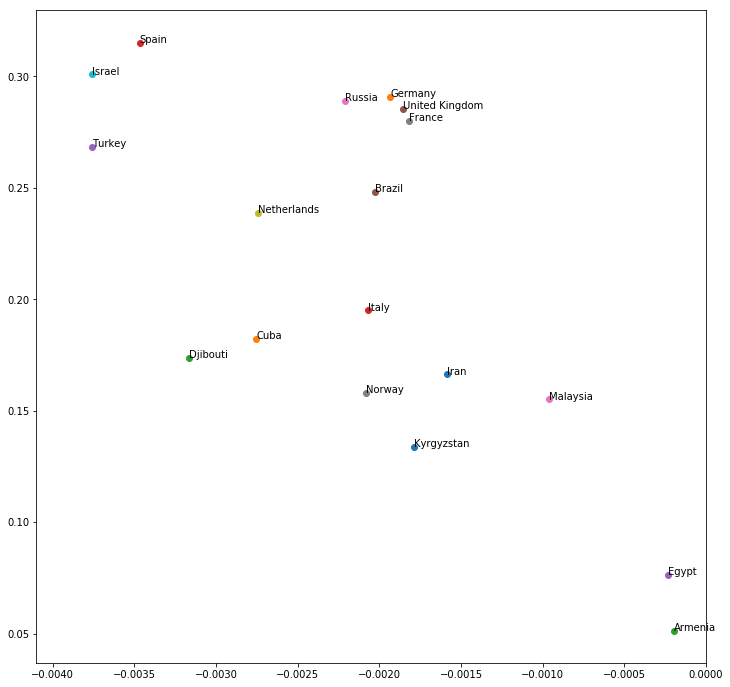

In [306]:
plt.figure(figsize=(12, 12))
for cof,country in zip(coefs,countries):
    plt.scatter(cof[1],cof[0])
    plt.annotate(country, (cof[1],cof[0]))
plt.xlim(-0.0041,0.00)

В целом, можно заметить некоторые скопления стран, которые сгруппированы по дате пикового дня (не удивительно, ведь координата пика как раз и зависит от двух параметров, являющимися координатами точки на данном графике). Страны в верхней левой части можно охарактеризовать резким ростом и резким прекращением роста заболевших. Для стран с малым по модулю значением при $t^2$ (правая часть графика) предполагается продолжительный рост и упадок числа заболевших. Радует, что правый верхний угол не занят, т.е. нет совсем уж плачевных историй. Печалит такая же пустота в левом нижнем углу, где были бы страны, быстро победившие вирус до его распространения. 

#### 5. 
#### Что вы поняли из этого упражнения? 


Получилось посмотреть другим взглядом на линейную регрессию. Слишком "теоретические" формулы открыли свой практический смысл. Удалось поработать с сигмоидой в том виде, в котором ранее не приходилось и понять, откуда это все берется. Немного неожиданно было увидеть некоторые численные значения для некоторых стран. 

#### Что можно сказать про коронавирус по итогам такого моделирования? 

Если наши наивные предположения о характере поведения эпидемии верны - склонен считать, что все будет не так печально. Многие страны вышли или уже выходят на спад и плато количества новых случаев. Раньше слышал оценки, что вся эта история должна продлиться на порядок дольше. Однако, нужно понимать, что все эти модели работают в "замороженном" и упрощенном мире. В реальности, зависимости на порядок сложнее, факторов на порядок больше. 

Моделирование, подобное сделанному скорее прототип, который может послужить основой для дальнейших экспериментов.

#### Как принять решение, например, о том, нужно ли вводить карантин?

В конктексте рассматриваемой задачи, на сегодняший день над этим вопросом думать не приходится, вводить придется...
В контексте начала распространения заболевания - думаю, можно оценить характер роста числа заболевших по первым данным. Можно сравнить полученную модель с аналогичными моделями из исторических данных, ознакомиться с примененными в той ситуации методами сдерживания и их эффективностью. Но, как мне кажется, оценка рискует быть слишком грубой в такой упрощенной модели, стоит вспомнить разброс построенных сигмоид.


##### P.S.
Немного чуть отвлеченной болтологии. Товарищи из медицины получали информацию от итальянских коллег на тему построения последними подобных моделей. В разговоре говорилось, что,мол, данные, которые предоставляет Россия, не похожи на правду. На деле заболевших должно быть больше, согласно их моделям, етц. Но, как бы, исходя из банальной логики, а теперь и проделанной работы, встает вопрос - а кто сказал, что вы вообще построили хоть сколько либо близкую к реальности модель? Даже по разделению на трейн и тест было видно, что сигмоида, которая отлично описывала данные на трейне, могла потом резко менять свое поведение на тесте. Как-то странно обвинять реальность в несоответсвии модели, а не наоборот. Да и в нашем случае никто не сказал, что характер роста будет именно сигмоидальный. Это мы решили, что это так, поэтому и модели нас устраивают, ибо описывают наши же предположения. На деле же может (и, на сколько я понимаю, дожна) быть вторая, а может и третья, волны роста заболеваний. 
Более того, если уж и занижали бы данные, то, думаю, делали бы это всегда и,как результат, предсказания просто были бы смещены, но модель же строилась по, предполагаемо, "фейковым" данным, а не реальным, ну и предиктить она должна фейк. Ну, либо, если включить все же режим конспирологов, врать стали не сразу или врут крайне плохо.
Да и если модель строилась на данных одних стран, то применять к другим странам не особо оправдано, если это только не какое-то супер пространство признаков, в наличие которого у исследователей верится с трудом.